# Testing methods from `utils/autocorr.py`

## Imports

In [1]:
import datetime
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from rich.console import Console
from rich.theme import Theme

sys.path.append('..')
sns.set_palette('bright')
%load_ext autoreload
%autoreload 2

console = Console(theme=Theme({"repr.number": "#ff79ff"}), width=240, log_time=True, log_time_format='[%X]')
#%matplotlib notebook
plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
%matplotlib inline

GREEN = '#87ff00'
PINK = '#F92672'
BLUE = '#007dff'
YELLOW = '#FFFF00'
RED = '#FF4050'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')

## `HMC` dirs:

In [3]:
import glob
from pathlib import Path

import utils.file_io as io
import utils.autocorr as autocorr

from config import LOGS_DIR


base_dirs_hmc = [
    os.path.abspath('/Users/saforem2/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc_2021_01_04/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc_2021_01_05/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc_2020-12-15/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs'),
    os.path.abspath('/Users/saforem2/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc_2020-12-15/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs'),
    os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc_2020_12_20/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
    os.path.abspath('/Users/saforem2thetaGPU/inference/hmc_2021_01_04/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/'),
]

hmc_dirs = []
for d in base_dirs_hmc:
    if os.path.isdir(d):
        console.log(f'Looking in {d}...')
        hmc_dirs += [x for x in Path(d).rglob('*HMC_L16*') if x.is_dir()]
        console.log(f'len(hmc_dirs): {len(hmc_dirs)}')
        
hmc_dirs = np.unique(hmc_dirs)

tf.__version__: 2.4.0-dev20201016


In [4]:
len(hmc_dirs)

132

## `L2HMC` dirs:

In [15]:
import utils.file_io as io
import utils.autocorr as acr

def _look(p, s, conds=None):
    matches = [x for x in Path(p).rglob(f'*{s}*')]
    if conds is not None:
        if isinstance(conds, (list, tuple)):
            for cond in conds:
                matches = [x for x in matches if cond(x)]
        else:
            matches = [x for x in matches if cond(x)]
    return matches

base_dirs_l2hmc = [
    os.path.abspath('/Users/saforem2/thetaGPU/training/'),
    os.path.abspath('/Users/saforem2/grand/projects/DLHMC/training/'),
]
l2hmc_dirs = []
for d in base_dirs_l2hmc:
    console.log(f'Looking in: {d}...')
    
    conds = (
        lambda x: 'GaugeModel_logs' in (str(x)),
        lambda x: 'HMC_' not in str(x),
        lambda x: Path(x).is_dir(),
        lambda x: os.path.isdir(os.path.join(str(x), 'run_data')),
        lambda x: os.path.isfile(os.path.join(str(x), 'run_params.z')),
    )
    l2hmc_dirs += _look(d, 'L16_b', conds)
    
    console.log(f'len(l2hmc_dirs): {len(l2hmc_dirs)}')

In [16]:
from copy import deepcopy
import utils.autocorr as acr

hdirs_bad = []
hdata = {b: {} for b in np.arange(1, 8)}
for idx, hdir in enumerate(hmc_dirs):
    console.log(f'({idx} / {len(hmc_dirs)}) hdir: {hdir}')
    tint_files = [x for x in Path(hdir).rglob('*tau_int_data.z*') if x.is_file()]
    tint_files += [x for x in Path(hdir).rglob('*tint_data.z*') if x.is_file()]
    for f in tint_files:
        loaded = io.loadz(f)
        
        if 'tau_int_data' in str(f):
            run_dir = os.path.dirname(os.path.split(f)[0])
        else:
            run_dir, _ = os.path.split(f)
            
        try:
            params = acr._get_important_params(run_dir)
        except (FileNotFoundError, ValueError) as err:
            console.log(f'err: {err}, skipping!', style=RED)
            hdirs_bad.append(hdir)
            continue
            
        tint = loaded.get('tint', loaded.get('tau_int', None))
        narr = loaded.get('narr', loaded.get('draws', None))
        
        if tint is not None and narr is not None:
            data = deepcopy(params)
            data.update({
                'tint': tint,
                'narr': narr,
            })

            beta = params['beta']
            traj_len = params['traj_len']
            hdata[beta][traj_len] = data

In [18]:
import joblib
from copy import deepcopy

ldirs_bad = []
ldata = {b: {} for b in np.arange(1, 8)}

for idx, ldir in enumerate(l2hmc_dirs):
    console.log(f'({idx}/{len(l2hmc_dirs)}) ldir: {ldir}')
    tint_files = [x for x in Path(ldir).rglob('*tint_data.z*') if x.is_file()]
    tint_files += [x for x in Path(ldir).rglob('*tau_int_data.z*') if x.is_file()]
    for f in tint_files:
        try:
            loaded = io.loadz(f)
        except ValueError:
            try:
                with open(f, 'rb') as ff:
                    loaded = joblib.load(ff)
            except ValueError:
                console.log(f'Unable to load!!!!', style=RED)
        
        if 'tau_int_data' in str(f):
            run_dir = os.path.dirname(os.path.split(f)[0])
        else:
            run_dir, _ = os.path.split(f)
            
        try:
            params = acr._get_important_params(run_dir)
        except (FileNotFoundError, ValueError) as err:
            console.log(f'err: {err}, skipping!', style=YELLOW)
            ldirs_bad.append(ldir)
            continue
            
        tint = loaded.get('tint', loaded.get('tau_int', None))
        narr = loaded.get('narr', loaded.get('draws', None))
        
        if tint is not None and narr is not None:
            data = deepcopy(params)
            data.update({
                'tint': tint,
                'narr': narr,
            })
            
            beta = params['beta']
            traj_len = params['traj_len']
            ldata[beta][traj_len] = data

In [9]:
for beta in betas:
    num_entries = len(list(ldata[beta].keys()))
            lredirs_bad.append(ldir)
    console.rule(f'beta: {beta}, {num_entries} entries')
    console.log(ldata[beta])

IndentationError: unexpected indent (<ipython-input-9-d5870b0ccb71>, line 3)

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


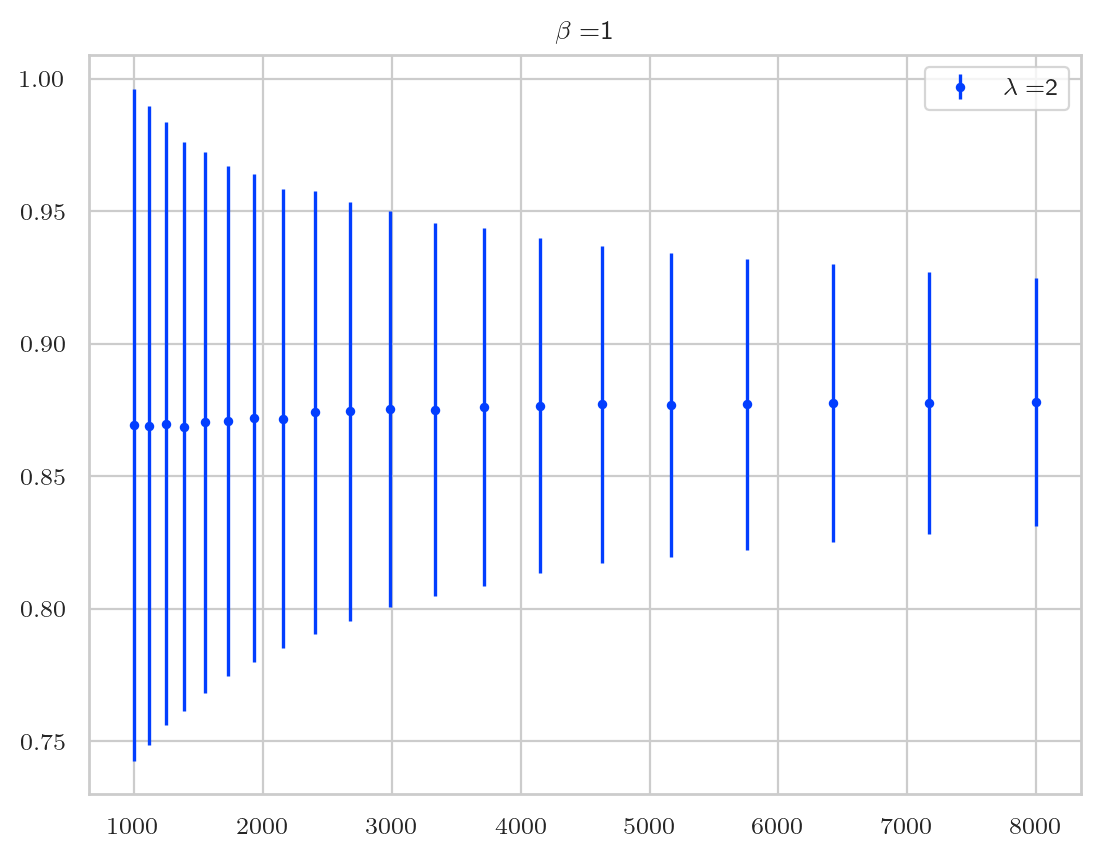

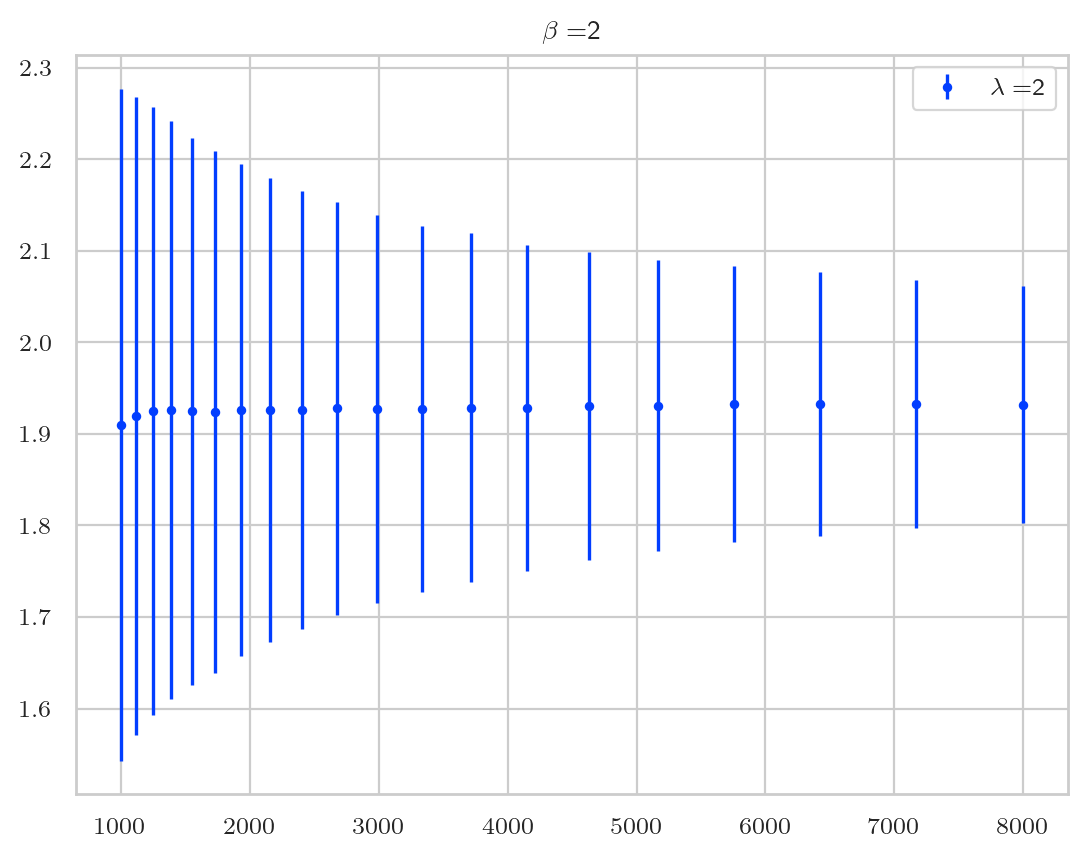

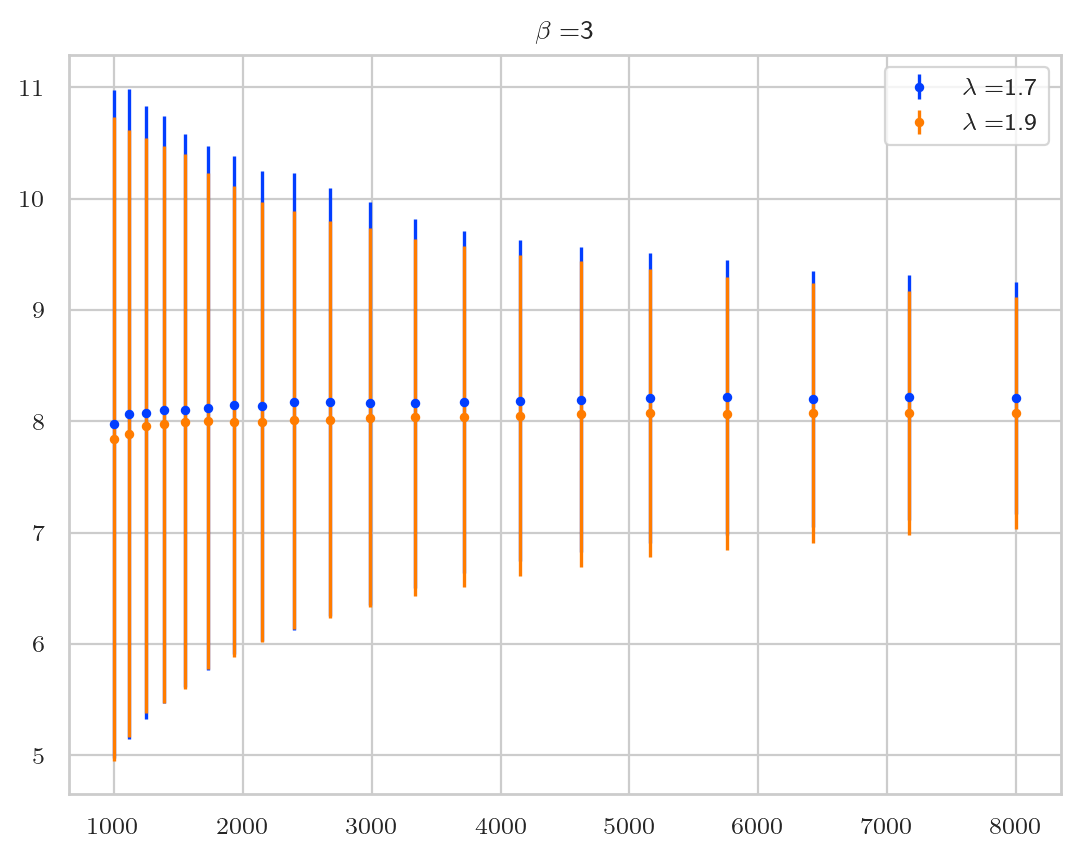

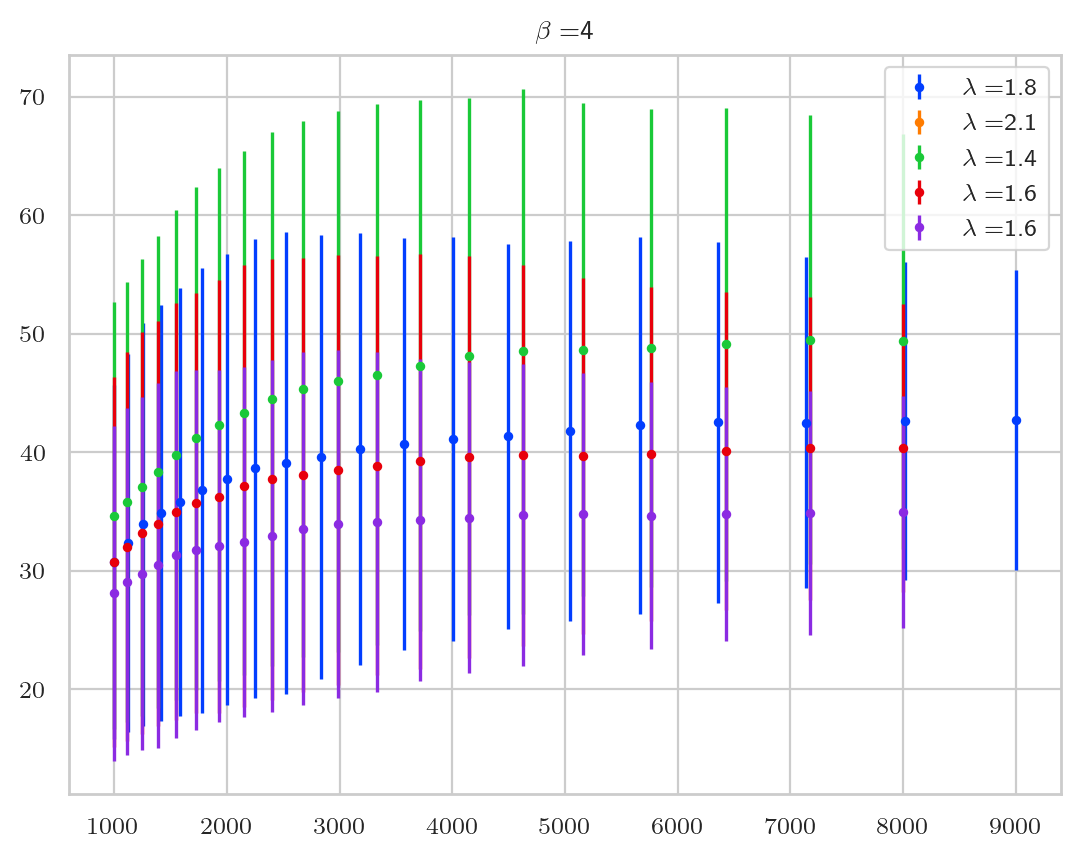

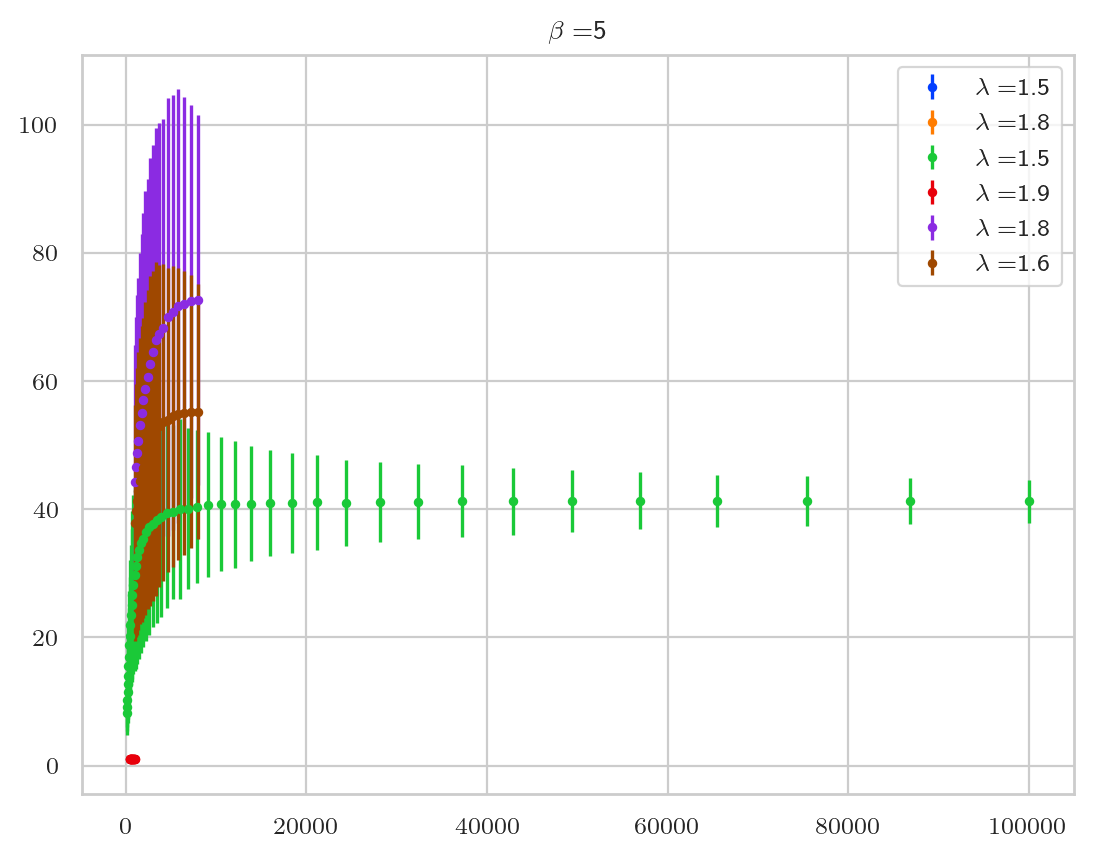

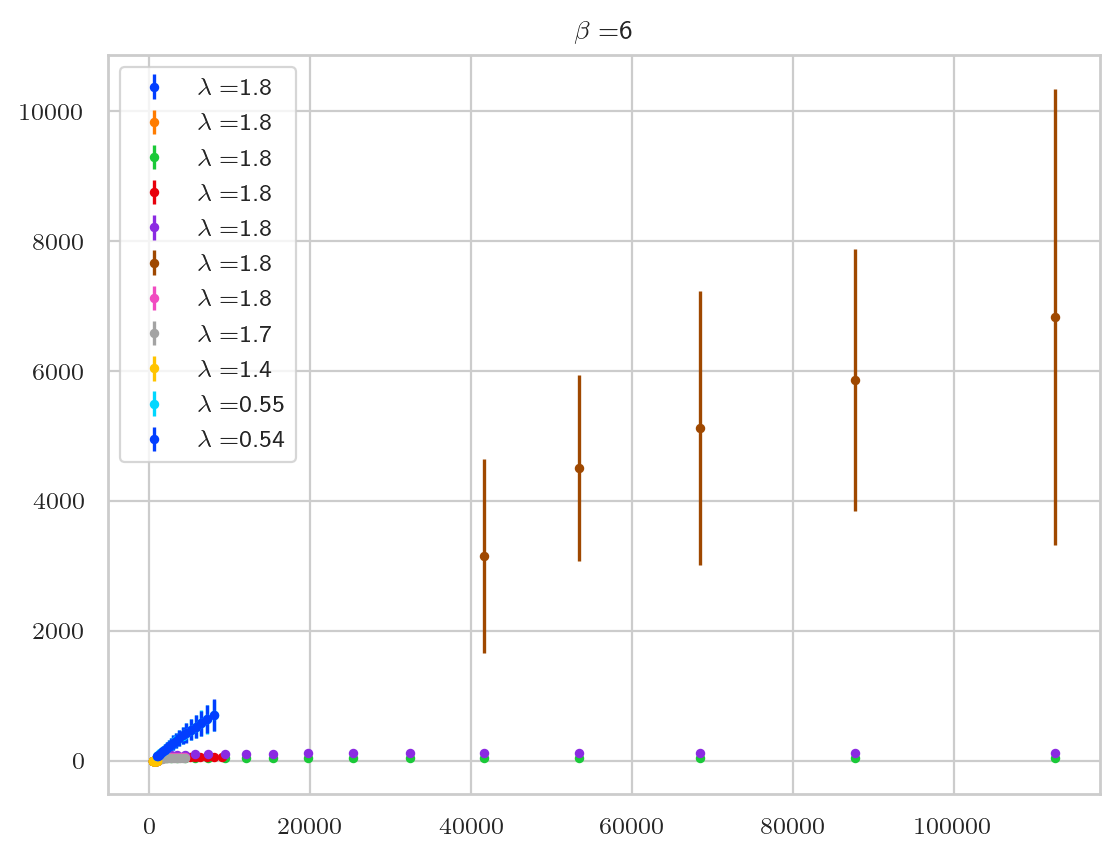

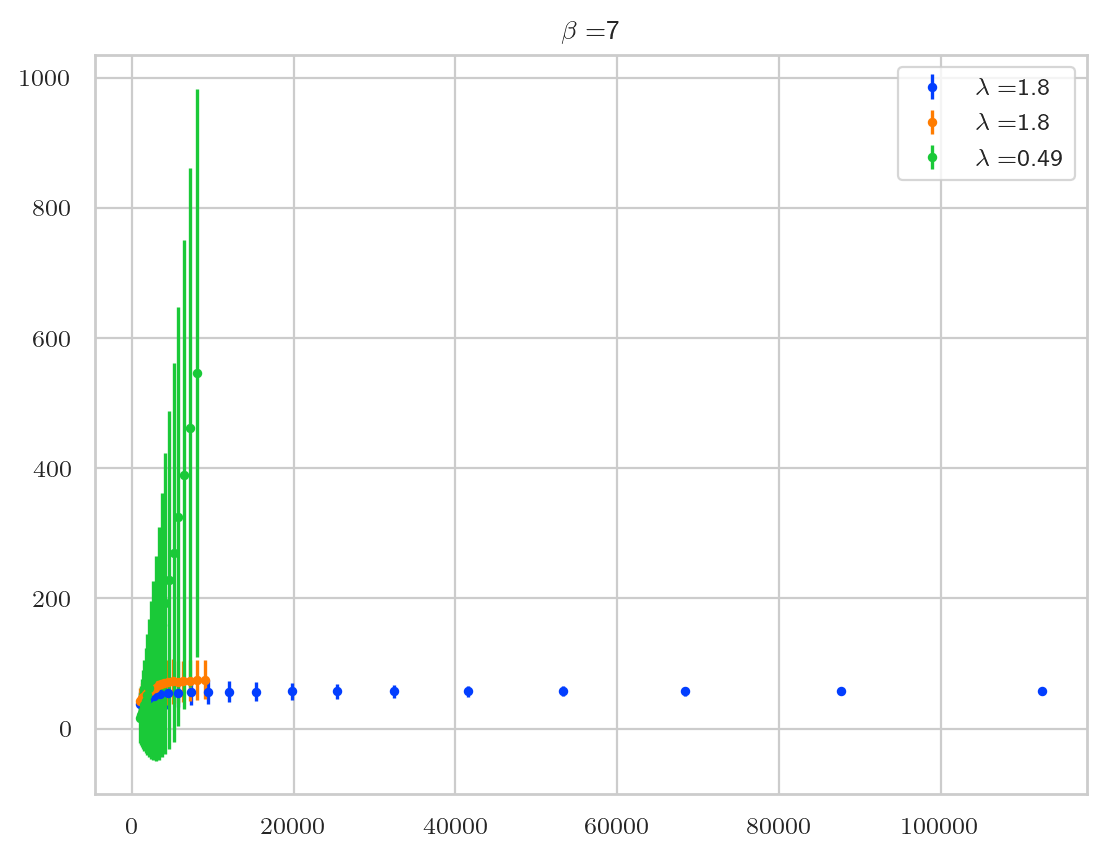

In [19]:
for beta, data in ldata.items():
    fig, ax = plt.subplots()
    for traj_len, tint in data.items():
        _ = ax.errorbar(tint['narr'], np.mean(tint['tint'], axis=-1), yerr=np.std(tint['tint'], axis=-1), ls='', marker='.', label=r'$\lambda = $' + f'{traj_len:.2g}')
        _ = ax.set_title(r'$\beta = $' + f'{beta}')
    _ = ax.legend(loc='best')

In [20]:
def get_annealing_schedule(run_dir):
    tail = str(run_dir).find('GaugeModel_logs')
    run_dir = run_dir[tail:]
    
    bidx = str(run_dir).find('bi')
    bfdx = str(run_dir).find('bf')
    
    bistr = run_dir[bidx:bidx+3]
    bfstr = run_dir[bfdx:bfdx+3]
    
    bi = float(bistr.lstrip('bi'))
    bf = float(bfstr.lstrip('bf'))
    
    astr = r"$\beta:$" + f' {bi}' + r"$\rightarrow$" + f'{bf}'
    
    return astr, (bi, bf)

In [21]:
plt.style.use('default')
sns.set_context('paper')
sns.set_palette('bright')
plt.rc('text', usetex=True)

In [63]:
x = 1.234
y = 1.23
z = 1.35
prec = 0.05

In [64]:
x - y
x - z

0.0040000000000000036

-0.1160000000000001

In [65]:
(x - y) / prec
(x - z) / prec

0.08000000000000007

-2.320000000000002

In [68]:
np.isclose(x, y, rtol=0.01)

True

In [ ]:
def check_close(a, b, prec=0.05)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

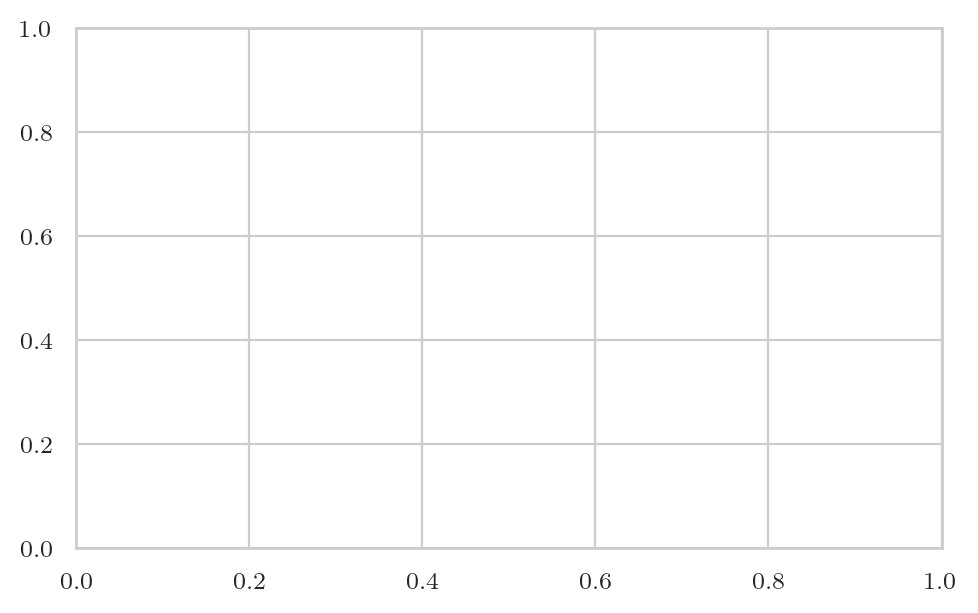

In [99]:
from cycler import cycler
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from config import PLOTS_DIR, MARKERS
from utils.plotting_utils import truncate_colormap, set_size

datestr = io.get_timestamp('%Y-%m-%d')
timestr = io.get_timestamp('%H%M')
outdir = os.path.join(PLOTS_DIR, f'autocorrs_{datestr}')
io.check_else_make_dir(outdir)

sns.set_context('paper')
sns.set_palette('bright')
plt.rc('text', usetex=True)

betas = np.arange(1, 8)
titles = {
    1.: r"$\beta = 1$",
    2.: r"$\beta = 2$",
    3.: r"$\beta = 3$",
    4.: r"$\beta = 4$",
    5.: r"$\beta = 5$",
    6.: r"$\beta = 6$",
    7.: r"$\beta = 7$",
}
set1_colors = [(228,26,28), (55,126,184), (77,175,74), (152,78,163),  (255,127,0), (255,255,51), (166,86,40), (247,129,191), (153,153,153)]
#set1_colors = np.array(set1_colors, dtype=float)
#set1_colors /= 255.0
#set1_colors = mcolor.to_rgba_array(set1[::2])
alt_colors = ["#7F3C8D", "#11A579", "#3969AC", "#F2B701", "#E73F74", "#80BA5A", "#E68310", "#A5AA99"]
default = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
colors = 10 * ['deeppink', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

pink_yellow = ["#fef6b5", "#ffdd9a", "#ffc285", "#ffa679", "#fa8a76", "#f16d7a", "#e15383"]
sunset = ["#f3e79b", "#fac484", "#f8a07e", "#eb7f86", "#ce6693", "#a059a0", "#5c53a5"]
plt.style.use('default')
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('bright')
plt.rc('text', usetex=True)

markers = 10 * ['s', 'd', '^', 'v', '<', '>', 'o', '*']
#cycler('color', ['deeppink', 'dodgerblue', 'lawngreen', 'violet', 'orangered', 'deepskyblue', 'slategrey', 'aquamarine']) #'cyan', 'm', 'y', 'k'])

tint_tlen_hmc = {beta: {} for beta in betas}
tint_tlen_l2hmc = {beta: {} for beta in betas}
bad_l2hmc_run_dirs = {beta: {} for beta in betas}

for beta in betas:
    fig, ax = plt.subplots(figsize=set_size(), constrained_layout=True)
        
    htlens = []
    htdata = dict(sorted(hdata[beta].items()))
    cmap = truncate_colormap('cet_gray', minval=0.1, maxval=0.9, n=len(list(htdata.keys())))
    for idx, (traj_len, ht) in enumerate(htdata.items()):
        lf = ht['lf']
        x = ht['narr']
        y = lf * ht['tint']
        yerr = lf * ht['tint'] / np.log(10)
        
        if beta == 4. and np.max(x) > 5e4:
            continue
        
        keep = np.isfinite(y)
        #x = x[keep]
        y = y[keep]
        yerr = yerr[keep]
        htlens.append(traj_len)
        
        if beta == 7.:
            keep = np.squeeze(np.where(y > 1000))
            #x = x[keep]
            y = y[keep]
            yerr = yerr[keep]
            
        tint_tlen_hmc[beta].update({
            traj_len: {
                'x': x,
                'y': y,
                'yerr': yerr,
                'params': ht.get('run_params', None),
            }
        })
        
        color = cmap(traj_len / 4.)
        mec = cmap((traj_len - 0.25 * traj_len)/ 4.)
        label = None
        for jdx in range(10):
            if jdx == 0 and idx == 0:
                label = r'$\lambda = $' + f'{traj_len:.3g}'
                label += ' (HMC)'
                
            _ = ax.errorbar(x, y[:, jdx], yerr=yerr[:, jdx],
                            ls='', marker='.',
                            markersize=2.5,
                            fillstyle='none',  #mec=mec,
                            color=color)
                            #label=label)
            
    normalize = mcolor.Normalize(vmin=1., vmax=4.)
    scalarmappable = cm.ScalarMappable(norm=normalize, cmap=cmap)
    scalarmappable.set_array(np.unique(htlens))
    #fig.colorbar(im, orientation="horizontal", pad=0.2)

    colorbar = fig.colorbar(scalarmappable, ax=ax, label=r"$\lambda$ (HMC)")
    
    ltdata = dict(sorted(ldata[beta].items()))
    #cmap = truncate_colormap('viridis', minval=0., maxval=1., n=len(list(ltdata.keys())))
    #maxval = np.max(list(ltdata.keys()))
    for idx, (traj_len, lt) in enumerate(ltdata.items()):
        if traj_len < 1.:
            continue
            
        if beta == 6.:
            if traj_len < 1.78:
                continue
            
        run_dir = lt['run_params']['run_dir']
        astr, (bi, bf) = get_annealing_schedule(run_dir)
        
        if bf != beta:
            console.log(f'bf != beta ???? (bf: {bf}, beta: {beta})', style=RED)
            continue
        
        if beta == 5.:
            if np.isclose(traj_len, 1.55, 0.01) or np.isclose(traj_len, 1.92, 0.01):
                bad_l2hmc_run_dirs[beta].update({
                    traj_len: {
                        'params': lt.get('run_params', None),
                    },
                })
                continue
                
        if beta == 6.:
            c1 = np.isclose(traj_len, 1.7846, 0.001)
            c2 = np.isclose(traj_len, 1.8226, 0.001)
            c3 = np.isclose(traj_len, 1.8414, 0.001)
            if c1 or c2 or c3:
                bad_l2hmc_run_dirs[beta].update({
                    traj_len: {
                        'params': lt.get('run_params', None),
                    }
                })
                continue
        
        lf = lt['lf']
        x = lt['narr']
        
        y = lf * lt['tint']
        yerr = lf * lt['tint'] / np.log(10)
        try:
            keep = np.squeeze(np.where(y < 10000))
            #x = x[keep[0, :]]
            y = y[keep]
            yerr = yerr[keep]
           
        except ValueError:
            continue
        #    
        keep = np.isfinite(y)
        #x = x[keep[0]]
        y = y[keep]
        yerr = yerr[keep]
        
        keep = np.where(x > 1000)
        #x = x[keep]
        y = y[keep]
        yerr = yerr[keep]
        
        tint_tlen_l2hmc[beta].update({
            traj_len: {
                'x': x,
                'y': y,
                'yerr': yerr,
                'params': ht.get('run_params', None),
            },
        })
        
        #mcolor.Normalize(vmin=0, vmax=1.jkjkjkj)
        
        for jdx in range(10):
            label = None
            if jdx == 0 and idx == 0:
                label = ', '.join([
                    r'$\lambda = $' + f'{traj_len:4.3g}, ',
                    f'{astr}'
                ])
                #if beta == 6.:
                #    label = r'$\lambda = $' + f'{traj_len:6.5g}, '
            _ = ax.errorbar(x, y[:, jdx], yerr=yerr[:, jdx],
                            ls='', marker=markers[idx],
                            markersize=2.5,
                            color=colors[idx],
                            #color=cmap(traj_len),
                            #color='',
                            #fillstyle='none',
                            label=label)
        
    _ = ax.set_title(titles[beta])
    _ = ax.legend(loc='best', fontsize='x-small')
    #_ = ax.set_xlim((900, ax.get_xlim()[-1]))
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    _ = ax.set_ylabel(r"$N_{\mathrm{LF}}\cdot \tau_{\mathrm{int}}$")
    _ = ax.set_xlabel('MC Step')
    _ = ax.grid(True, alpha=0.4)
    
    
    outfile = os.path.join(outdir, f'autocorr_beta{int(beta)}.pdf')
    _ = plt.savefig(outfile, dpi=400, bbox_inches='tight')

In [91]:
%debug

> <ipython-input-90-f4e4436d470a>(151)<module>()
    149             keep = np.squeeze(np.where(y < 10000))
    150             x = x[keep[0, :]]
--> 151             y = y[keep]
    152             yerr = yerr[keep]
    153 

ipdb> keep.shape
(2, 40960)
ipdb> x.shape
(40960,)
ipdb> x[keep[-1]]
array([999, 999, 999, ..., 999, 999, 999])
ipdb> keep[-1].shape
(40960,)
ipdb> keep[0]
array([ 0,  0,  0, ..., 19, 19, 19])
ipdb> keep[0].shape
(40960,)
ipdb> keep[:].shape
(2, 40960)
ipdb> y.shape
(20, 2048)
ipdb> quit


In [89]:
%debug

> <ipython-input-88-f9a13b922481>(158)<module>()
    156 
    157         keep = np.isfinite(y.mean(axis=-1))
--> 158         x = x[keep]
    159         y = y[:, keep]
    160         yerr = yerr[:, keep]

ipdb> x.shape
(20,)
ipdb> keep
array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])
ipdb> keeps = np.isfinite(y)
ipdb> keeps
array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]],

       [[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]],

       [[ True,  True,  True,  True,  True,  True,  True,  T

         True,  True]])
ipdb> np.squeeze(keeps).shape
(20, 20)
ipdb> q


ValueError: not enough values to unpack (expected 2, got 1)

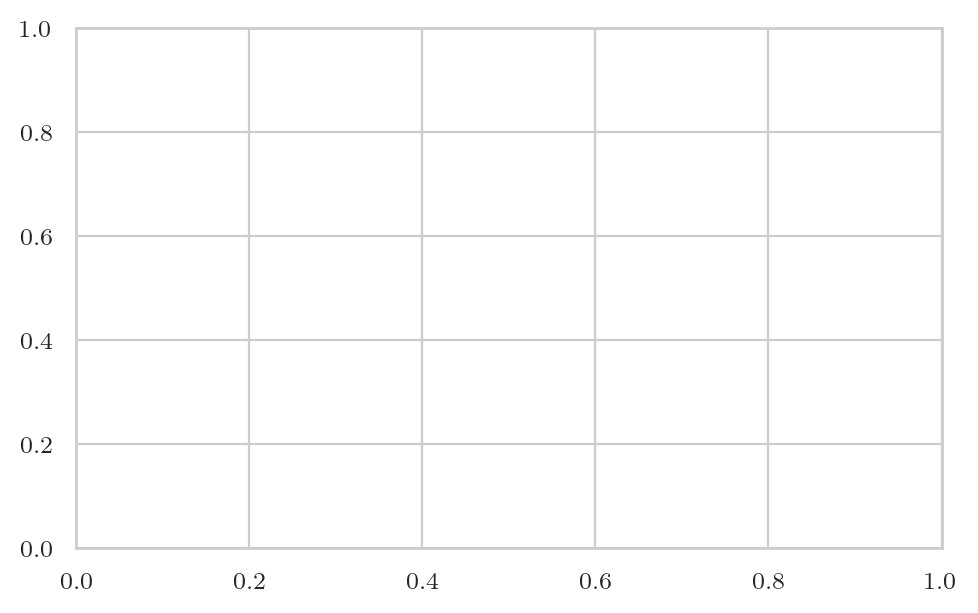

In [83]:
for beta in betas:
    fig, ax = plt.subplots(figsize=set_size(), constrained_layout=True)
        
    cmap = truncate_colormap('cet_gray', minval=0.1, maxval=0.9, n=len(list(htdata.keys())))
    
    hdata_ = dict(sorted(tint_tlen_hmc[beta].items()))
    
    for idx, (traj_len, ht) in enumerate(hdata_.items()):
        x = ht['x']
        y = ht['y']
        yerr = ht['yerr']
        num_steps, batch_size = y.shape
        xtlen = batch_size * [traj_len]
        ytlen = y[-1]
        yerrtlen = yerr[-1]
        _ = ax.errorbar(xtlen, ytlen, yerr=yerrtlen,
                        ls='', marker='.',
                        markersize=2.5,
                        fillstyle='none',  #mec=mec,
                        color=color)
                        #label=label)

In [84]:
%debug

> <ipython-input-83-ba58dac8c5f7>(12)<module>()
     10         y = ht['y']
     11         yerr = ht['yerr']
---> 12         num_steps, batch_size = y.shape
     13         xtlen = batch_size * [traj_len]
     14         ytlen = y[-1]

ipdb> y.shape
(20,)
ipdb> x.shape
(20,)
ipdb> quit


In [29]:
%debug

> <ipython-input-28-84f376daf9d1>(3)<module>()
      1 for beta, tint in ldata.items():
      2     fig, ax = plt.subplots()
----> 3     _ = ax.errorbar(tint['narr'], np.mean(tint['tint'], axis=-1), yerr=np.std(tint['tint'], axis=-1))
      4     _ = ax.set_title(r'$\beta = $' + f'{beta}')

ipdb> tint.keys()
dict_keys([2.042798])
ipdb> tint.values()
dict_values([{'lf': 11, 'eps': 0.18570891, 'traj_len': 2.042798, 'beta': 1.0, 'run_params': {'hmc': False, 'run_dir': '/lus/grand/projects/DLHMC/training/2021_01_22/t16x16b2048lf10bi1bf1NadamSwish/l2hmc-qcd/logs/GaugeModel_logs/2021_01/L16_b2048_lf11_actswish_bi1_bf1_dp01_sepNets_NCProj/inference/L16_b2048__lf11_eps005-2021-01-23-0822', 'beta': 1.0, 'run_steps': 10000, 'plaq_weight': 0.0, 'charge_weight': 0.01, 'x_shape': (2048, 512), 'num_steps': 11, 'net_weights': NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0), 'input_shape': (2048, 512), 'xeps': ListWrapper([<tf.Vari

In [19]:
import utils.autocorr as acr

betas = np.arange(1, 8)
ltint = {
    b: {} for b in betas
}
for idx, ldir in enumerate(l2hmc_dirs):
    console.log(f'({idx}/{len(l2hmc_dirs)}) ldir: {ldir}')
    data = acr._deal_with_new_data
    data = acr.deal_with_new_data(ldir, save=False)
    beta = data['beta']
    ltint[beta].update(data)

KeyError: 'beta'

In [ ]:
for key, val in ltint.items():
    console.rule(f'beta: {beta}')
    console.log(val)

In [26]:
ltint[2.].keys()

dict_keys([2.0219007])

KeyError: 'narr'

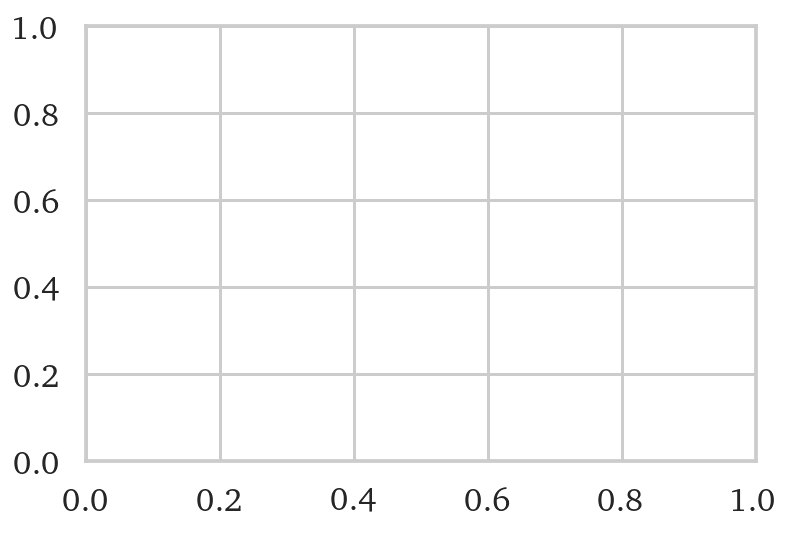

In [25]:
for beta, tint in ltint.items():
    fig, ax = plt.subplots()
    _ = ax.errorbar(tint['narr'], np.mean(tint['tint'], axis=-1), yerr=np.std(tint['tint'], axis=-1))

In [ ]:
data